<a href="https://colab.research.google.com/github/shubhamksingh1/RecommendationEngine/blob/main/CollaborativeFiltering/MovieLens/Keras/collaborative_filtering_keras_movielens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Collaborative Filtering for Movie Recommendations


## Introduction

This example demonstrates
[Collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering)
using the [Movielens dataset](https://www.kaggle.com/c/movielens-100k)
to recommend movies to users.
The MovieLens ratings dataset lists the ratings given by a set of users to a set of movies.
Our goal is to be able to predict ratings for movies a user has not yet watched.
The movies with the highest predicted ratings can then be recommended to the user.

The steps in the model are as follows:

1. Map user ID to a "user vector" via an embedding matrix
2. Map movie ID to a "movie vector" via an embedding matrix
3. Compute the dot product between the user vector and movie vector, to obtain
the a match score between the user and the movie (predicted rating).
4. Train the embeddings via gradient descent using all known user-movie pairs.

**References:**

- [Collaborative Filtering](https://dl.acm.org/doi/pdf/10.1145/371920.372071)
- [Neural Collaborative Filtering](https://dl.acm.org/doi/pdf/10.1145/3038912.3052569)


In [ ]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt


## First, load the data and apply preprocessing


In [ ]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)


983040/978202 [==============================] - 0s 0us/step
Extracting all the files now...
Done!


In [ ]:
df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [ ]:
df.to_csv("/content/drive/MyDrive/Collaborative_Keras/movie_lens.csv",index=False)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Collaborative_Keras/movie_lens.csv")

In [ ]:
df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


First, need to perform some preprocessing to encode users and movies as integer indices.


In [ ]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}


In [ ]:
print(user_ids)
print(user2user_encoded)
print(userencoded2user)


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

In [ ]:
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

In [ ]:
print(movie_ids)
print(movie2movie_encoded)
print(movie_encoded2movie)

[1, 3, 6, 47, 50, 70, 101, 110, 151, 157, 163, 216, 223, 231, 235, 260, 296, 316, 333, 349, 356, 362, 367, 423, 441, 457, 480, 500, 527, 543, 552, 553, 590, 592, 593, 596, 608, 648, 661, 673, 733, 736, 780, 804, 919, 923, 940, 943, 954, 1009, 1023, 1024, 1025, 1029, 1030, 1031, 1032, 1042, 1049, 1060, 1073, 1080, 1089, 1090, 1092, 1097, 1127, 1136, 1196, 1197, 1198, 1206, 1208, 1210, 1213, 1214, 1219, 1220, 1222, 1224, 1226, 1240, 1256, 1258, 1265, 1270, 1275, 1278, 1282, 1291, 1298, 1348, 1377, 1396, 1408, 1445, 1473, 1500, 1517, 1552, 1573, 1580, 1587, 1617, 1620, 1625, 1644, 1676, 1732, 1777, 1793, 1804, 1805, 1920, 1927, 1954, 1967, 2000, 2005, 2012, 2018, 2028, 2033, 2046, 2048, 2054, 2058, 2078, 2090, 2093, 2094, 2096, 2099, 2105, 2115, 2116, 2137, 2139, 2141, 2143, 2161, 2174, 2193, 2253, 2268, 2273, 2291, 2329, 2338, 2353, 2366, 2387, 2389, 2395, 2406, 2414, 2427, 2450, 2459, 2470, 2478, 2492, 2502, 2528, 2529, 2542, 2571, 2580, 2596, 2616, 2617, 2628, 2640, 2641, 2644, 2648, 2

In [ ]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
df.tail()

,userId,movieId,rating,timestamp
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352
100835,610,170875,3.0,1493846415


In [ ]:

df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

In [ ]:
df.head()

,userId,movieId,rating,timestamp,user,movie
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,1
2,1,6,4.0,964982224,0,2
3,1,47,5.0,964983815,0,3
4,1,50,5.0,964982931,0,4


In [ ]:
df.tail()

,userId,movieId,rating,timestamp,user,movie
100831,610,166534,4.0,1493848402,609,3120
100832,610,168248,5.0,1493850091,609,2035
100833,610,168250,5.0,1494273047,609,3121
100834,610,168252,5.0,1493846352,609,1392
100835,610,170875,3.0,1493846415,609,2873


In [ ]:
num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
print("num_users",num_users)
print("num_movies",num_movies)

num_users 610
num_movies 9724


In [ ]:

df["rating"] = df["rating"].values.astype(np.float32)

In [ ]:
df

,userId,movieId,rating,timestamp,user,movie
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,1
2,1,6,4.0,964982224,0,2
3,1,47,5.0,964983815,0,3
4,1,50,5.0,964982931,0,4
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,609,3120
100832,610,168248,5.0,1493850091,609,2035
100833,610,168250,5.0,1494273047,609,3121
100834,610,168252,5.0,1493846352,609,1392


In [ ]:

# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

In [ ]:


print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)


Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


## Prepare training and validation data


In [ ]:
df

,userId,movieId,rating,timestamp,user,movie
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,1
2,1,6,4.0,964982224,0,2
3,1,47,5.0,964983815,0,3
4,1,50,5.0,964982931,0,4
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,609,3120
100832,610,168248,5.0,1493850091,609,2035
100833,610,168250,5.0,1494273047,609,3121
100834,610,168252,5.0,1493846352,609,1392


In [ ]:
df = df.sample(frac=1, random_state=42)

In [ ]:
df

,userId,movieId,rating,timestamp,user,movie
67037,432,77866,4.5,1335139641,431,4730
42175,288,474,3.0,978465565,287,474
93850,599,4351,3.0,1498524542,598,2631
6187,42,2987,4.0,996262677,41,194
12229,75,1610,4.0,1158989841,74,727
...,...,...,...,...,...,...
6265,42,4005,4.0,996259059,41,1873
54886,364,141,4.0,869443367,363,524
76820,480,6867,4.0,1179163171,479,2240
860,6,981,3.0,845556567,5,712


In [ ]:

x = df[["user", "movie"]].values

In [ ]:
x

array([[ 431, 4730],
       [ 287,  474],
       [ 598, 2631],
       ...,
       [ 479, 2240],
       [   5,  712],
       [ 102, 2046]])

In [ ]:

# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

In [ ]:
y

array([0.88888889, 0.55555556, 0.55555556, ..., 0.77777778, 0.55555556,
       1.        ])

In [ ]:

# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])

In [ ]:

x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)


In [ ]:
print(x_train,y_train)

[[ 431 4730]
 [ 287  474]
 [ 598 2631]
 ...
 [ 589 5054]
 [ 135  636]
 [ 274 3747]] [0.88888889 0.55555556 0.55555556 ... 0.55555556 1.         0.11111111]


In [ ]:
print(x_val,y_val)

[[ 324 1018]
 [   0    2]
 [ 103 4229]
 ...
 [ 479 2240]
 [   5  712]
 [ 102 2046]] [0.55555556 0.77777778 0.55555556 ... 0.77777778 0.55555556 1.        ]


## Create the model

We embed both users and movies in to 50-dimensional vectors.

The model computes a match score between user and movie embeddings via a dot product,
and adds a per-movie and per-user bias. The match score is scaled to the `[0, 1]`
interval via a sigmoid (since our ratings are normalized to this range).


In [ ]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)


## Train the model based on the data split


In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=50,
    verbose=1,
    validation_data=(x_val, y_val),
)


NameError: ignored

In [ ]:
model.summary()

Model: "recommender_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  30500     
_________________________________________________________________
embedding_1 (Embedding)      multiple                  610       
_________________________________________________________________
embedding_2 (Embedding)      multiple                  486200    
_________________________________________________________________
embedding_3 (Embedding)      multiple                  9724      
Total params: 527,034
Trainable params: 527,034
Non-trainable params: 0
_________________________________________________________________


## Plot training and validation loss


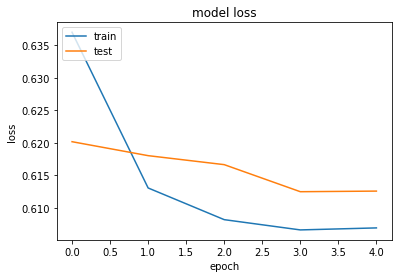

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


## Show top 10 movie recommendations to a user


In [ ]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")


In [ ]:
movie_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [ ]:
movie_df.to_csv("/content/drive/MyDrive/Collaborative_Keras/movie_info.csv",index=False)

In [ ]:
movie_df = pd.read_csv("/content/drive/MyDrive/Collaborative_Keras/movie_info.csv")

In [ ]:
movie_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation



# Let us get a user and see the top recommendations.

In [ ]:

user_id = df.userId.sample(1).iloc[0]

In [ ]:
user_id

77

In [ ]:

movies_watched_by_user = df[df.userId == user_id]

In [ ]:
movies_watched_by_user

,userId,movieId,rating,timestamp,user,movie
12396,77,5378,5.0,1535107567,76,757
12387,77,2571,5.0,1535107478,76,166
12385,77,1198,5.0,1535107476,76,70
12407,77,33794,5.0,1535107540,76,809
12401,77,6539,4.0,1535107525,76,770
12400,77,5989,2.0,1535107548,76,765
12395,77,5349,5.0,1535107538,76,756
12393,77,4973,2.5,1535107527,76,1125
12403,77,7361,2.0,1535107532,76,1129
12409,77,58559,5.0,1535107519,76,238


In [ ]:
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]

In [ ]:
movies_not_watched

0            1
1            2
2            3
3            4
4            5
         ...  
9737    193581
9738    193583
9739    193585
9740    193587
9741    193609
Name: movieId, Length: 9713, dtype: int64

In [ ]:
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)

In [ ]:
print(movies_not_watched)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 32799, 34, 131098, 36, 131104, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 65585, 52, 53, 54, 55, 65588, 57, 58, 98361, 60, 61, 62, 63, 64, 65, 66, 65596, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 163925, 92, 93, 94, 95, 96, 97, 32862, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 32875, 110, 111, 112, 113, 65642, 65651, 116, 117, 118, 119, 121, 122, 123, 32892, 125, 126, 128, 129, 32898, 132, 135, 137, 32906, 140, 141, 163981, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 131237, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 183, 184, 185, 186, 187, 188, 189, 190, 191, 98491, 193, 194, 195, 196, 98499, 198, 199, 98503, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 222, 2

In [ ]:
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]

In [ ]:
print(movies_not_watched)

[[0], [481], [1], [482], [483], [2], [484], [485], [5017], [486], [487], [1399], [488], [3678], [489], [490], [491], [2657], [492], [3604], [291], [493], [2163], [494], [495], [496], [497], [2430], [2068], [6914], [259], [292], [8955], [460], [3938], [461], [3939], [1859], [462], [6704], [498], [5992], [499], [971], [293], [500], [3], [1400], [5596], [4], [4529], [294], [3711], [501], [3679], [3811], [2651], [295], [3635], [502], [503], [504], [5832], [1401], [505], [506], [1290], [4035], [2663], [5], [4663], [5550], [4698], [2420], [5018], [507], [9348], [2421], [508], [6915], [4036], [2503], [5687], [4037], [509], [510], [511], [512], [4432], [513], [514], [2431], [515], [8152], [5289], [9533], [5551], [516], [6], [517], [8579], [518], [519], [296], [1402], [9349], [2799], [7], [1093], [520], [521], [4765], [5643], [4038], [9411], [1403], [7421], [2504], [2543], [6019], [4309], [297], [298], [6144], [6446], [2800], [4875], [522], [9561], [6769], [523], [524], [9723], [2544], [525], [

In [ ]:

user_encoder = user2user_encoded.get(user_id)

In [ ]:
user_encoder

76

In [ ]:
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)

In [ ]:
user_movie_array

array([[  76,    0],
       [  76,  481],
       [  76,    1],
       ...,
       [  76, 3870],
       [  76, 2989],
       [  76, 7869]])

In [ ]:

ratings = model.predict(user_movie_array).flatten()

In [ ]:
ratings

array([0.7040775 , 0.597341  , 0.5810373 , ..., 0.6952071 , 0.7016001 ,
       0.65622085], dtype=float32)

In [ ]:

top_ratings_indices = ratings.argsort()[-10:][::-1]

In [ ]:
top_ratings_indices

array([1026, 1065, 1034, 1083, 1071,  300, 1062, 1079, 1072, 1038])

In [ ]:
print(movies_not_watched)

[[0], [481], [1], [482], [483], [2], [484], [485], [5017], [486], [487], [1399], [488], [3678], [489], [490], [491], [2657], [492], [3604], [291], [493], [2163], [494], [495], [496], [497], [2430], [2068], [6914], [259], [292], [8955], [460], [3938], [461], [3939], [1859], [462], [6704], [498], [5992], [499], [971], [293], [500], [3], [1400], [5596], [4], [4529], [294], [3711], [501], [3679], [3811], [2651], [295], [3635], [502], [503], [504], [5832], [1401], [505], [506], [1290], [4035], [2663], [5], [4663], [5550], [4698], [2420], [5018], [507], [9348], [2421], [508], [6915], [4036], [2503], [5687], [4037], [509], [510], [511], [512], [4432], [513], [514], [2431], [515], [8152], [5289], [9533], [5551], [516], [6], [517], [8579], [518], [519], [296], [1402], [9349], [2799], [7], [1093], [520], [521], [4765], [5643], [4038], [9411], [1403], [7421], [2504], [2543], [6019], [4309], [297], [298], [6144], [6446], [2800], [4875], [522], [9561], [6769], [523], [524], [9723], [2544], [525], [

In [ ]:
print(movies_not_watched[1038][0])
print(movie_encoded2movie.get(353)) #movieid

353
1225


In [ ]:

recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]


In [ ]:
recommended_movie_ids

[1213, 1252, 1221, 1270, 1258, 318, 1249, 1266, 1259, 1225]

In [ ]:

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)


Showing recommendations for user: 77
Movies with high ratings from user
--------------------------------
Star Wars: Episode V - The Empire Strikes Back (1980) : Action|Adventure|Sci-Fi
Gladiator (2000) : Action|Adventure|Drama
Star Wars: Episode II - Attack of the Clones (2002) : Action|Adventure|Sci-Fi|IMAX
Lord of the Rings: The Return of the King, The (2003) : Action|Adventure|Drama|Fantasy
Spider-Man 2 (2004) : Action|Adventure|Sci-Fi|IMAX
--------------------------------
Top 10 movie recommendations
--------------------------------
Shawshank Redemption, The (1994) : Crime|Drama
Goodfellas (1990) : Crime|Drama
Godfather: Part II, The (1974) : Crime|Drama
Amadeus (1984) : Drama
Femme Nikita, La (Nikita) (1990) : Action|Crime|Romance|Thriller
Chinatown (1974) : Crime|Film-Noir|Mystery|Thriller
Shining, The (1980) : Horror
Stand by Me (1986) : Adventure|Drama
Unforgiven (1992) : Drama|Western
Back to the Future (1985) : Adventure|Comedy|Sci-Fi


# Save Load and Predict Again

In [ ]:
model.summary()

Model: "recommender_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  30500     
_________________________________________________________________
embedding_1 (Embedding)      multiple                  610       
_________________________________________________________________
embedding_2 (Embedding)      multiple                  486200    
_________________________________________________________________
embedding_3 (Embedding)      multiple                  9724      
Total params: 527,034
Trainable params: 527,034
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.save("/content/drive/MyDrive/Collaborative_Keras/Model/modelv1", save_format='tf')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Collaborative_Keras/Model/modelv1/assets


In [ ]:
new_model = load_model('/content/drive/MyDrive/Collaborative_Keras/Model/modelv1')

In [ ]:
new_model.summary()

Model: "recommender_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  30500     
_________________________________________________________________
embedding_1 (Embedding)      multiple                  610       
_________________________________________________________________
embedding_2 (Embedding)      multiple                  486200    
_________________________________________________________________
embedding_3 (Embedding)      multiple                  9724      
Total params: 527,034
Trainable params: 527,034
Non-trainable params: 0
_________________________________________________________________


In [ ]:

ratings_load = new_model.predict(user_movie_array).flatten()

In [ ]:
ratings_load

array([0.7040775 , 0.597341  , 0.5810373 , ..., 0.6952071 , 0.7016001 ,
       0.65622085], dtype=float32)

In [ ]:
ratings

array([0.7040775 , 0.597341  , 0.5810373 , ..., 0.6952071 , 0.7016001 ,
       0.65622085], dtype=float32)

In [ ]:
user_id_in = int(input("Enter User ID:"))

Enter User ID:27


In [ ]:
df

,userId,movieId,rating,timestamp,user,movie
67037,432,77866,4.5,1335139641,431,4730
42175,288,474,3.0,978465565,287,474
93850,599,4351,3.0,1498524542,598,2631
6187,42,2987,4.0,996262677,41,194
12229,75,1610,4.0,1158989841,74,727
...,...,...,...,...,...,...
6265,42,4005,4.0,996259059,41,1873
54886,364,141,4.0,869443367,363,524
76820,480,6867,4.0,1179163171,479,2240
860,6,981,3.0,845556567,5,712


In [ ]:
df.to_csv("/content/drive/MyDrive/Collaborative_Keras/movie_lens_pred_df.csv",index=False)

## To be used in pred file

In [ ]:
movie_df_load = pd.read_csv("/content/drive/MyDrive/Collaborative_Keras/movie_info.csv")
df2 = pd.read_csv("/content/drive/MyDrive/Collaborative_Keras/movie_lens_pred_df.csv")

In [ ]:

# Let us get a user and see the top recommendations.
movies_watched_by_user_load = df2[df2.userId == user_id_in]
movies_not_watched_load = movie_df_load[
    ~movie_df_load["movieId"].isin(movies_watched_by_user_load.movieId.values)
]["movieId"]
movies_not_watched_load = list(
    set(movies_not_watched_load).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched_load = [[movie2movie_encoded.get(x)] for x in movies_not_watched_load]
user_encoder_load = user2user_encoded.get(user_id_in)
user_movie_array_load = np.hstack(
    ([[user_encoder_load]] * len(movies_not_watched_load), movies_not_watched_load)
)


ratings_load = new_model.predict(user_movie_array_load).flatten()
top_ratings_indices_load = ratings_load.argsort()[-10:][::-1]
recommended_movie_ids_load = [
    movie_encoded2movie.get(movies_not_watched_load[x][0]) for x in top_ratings_indices_load
]

print("Showing recommendations for user: {}".format(user_id_in))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user_load = (
    movies_watched_by_user_load.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows_load = movie_df_load[movie_df_load["movieId"].isin(top_movies_user_load)]
for row in movie_df_rows_load.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies_load = movie_df_load[movie_df_load["movieId"].isin(recommended_movie_ids_load)]
for row in recommended_movies_load.itertuples():
    print(row.title, ":", row.genres)


Showing recommendations for user: 27
Movies with high ratings from user
--------------------------------
Forrest Gump (1994) : Comedy|Drama|Romance|War
Charade (1963) : Comedy|Crime|Mystery|Romance|Thriller
Wallace & Gromit: The Wrong Trousers (1993) : Animation|Children|Comedy|Crime
To Kill a Mockingbird (1962) : Drama
Star Wars: Episode I - The Phantom Menace (1999) : Action|Adventure|Sci-Fi
--------------------------------
Top 10 movie recommendations
--------------------------------
Usual Suspects, The (1995) : Crime|Mystery|Thriller
Pulp Fiction (1994) : Comedy|Crime|Drama|Thriller
Shawshank Redemption, The (1994) : Crime|Drama
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) : Comedy|War
Reservoir Dogs (1992) : Crime|Mystery|Thriller
American History X (1998) : Crime|Drama
Fight Club (1999) : Action|Crime|Drama|Thriller
Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001) : Comedy|Romance
Lord of the Rings: The Fellowship of the Ring, The (2001) : Adven

### pickle to be used in test file

In [ ]:
print(movie2movie_encoded)

{1: 0, 3: 1, 6: 2, 47: 3, 50: 4, 70: 5, 101: 6, 110: 7, 151: 8, 157: 9, 163: 10, 216: 11, 223: 12, 231: 13, 235: 14, 260: 15, 296: 16, 316: 17, 333: 18, 349: 19, 356: 20, 362: 21, 367: 22, 423: 23, 441: 24, 457: 25, 480: 26, 500: 27, 527: 28, 543: 29, 552: 30, 553: 31, 590: 32, 592: 33, 593: 34, 596: 35, 608: 36, 648: 37, 661: 38, 673: 39, 733: 40, 736: 41, 780: 42, 804: 43, 919: 44, 923: 45, 940: 46, 943: 47, 954: 48, 1009: 49, 1023: 50, 1024: 51, 1025: 52, 1029: 53, 1030: 54, 1031: 55, 1032: 56, 1042: 57, 1049: 58, 1060: 59, 1073: 60, 1080: 61, 1089: 62, 1090: 63, 1092: 64, 1097: 65, 1127: 66, 1136: 67, 1196: 68, 1197: 69, 1198: 70, 1206: 71, 1208: 72, 1210: 73, 1213: 74, 1214: 75, 1219: 76, 1220: 77, 1222: 78, 1224: 79, 1226: 80, 1240: 81, 1256: 82, 1258: 83, 1265: 84, 1270: 85, 1275: 86, 1278: 87, 1282: 88, 1291: 89, 1298: 90, 1348: 91, 1377: 92, 1396: 93, 1408: 94, 1445: 95, 1473: 96, 1500: 97, 1517: 98, 1552: 99, 1573: 100, 1580: 101, 1587: 102, 1617: 103, 1620: 104, 1625: 105, 1

In [ ]:
print(user2user_encoded)

{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 26: 25, 27: 26, 28: 27, 29: 28, 30: 29, 31: 30, 32: 31, 33: 32, 34: 33, 35: 34, 36: 35, 37: 36, 38: 37, 39: 38, 40: 39, 41: 40, 42: 41, 43: 42, 44: 43, 45: 44, 46: 45, 47: 46, 48: 47, 49: 48, 50: 49, 51: 50, 52: 51, 53: 52, 54: 53, 55: 54, 56: 55, 57: 56, 58: 57, 59: 58, 60: 59, 61: 60, 62: 61, 63: 62, 64: 63, 65: 64, 66: 65, 67: 66, 68: 67, 69: 68, 70: 69, 71: 70, 72: 71, 73: 72, 74: 73, 75: 74, 76: 75, 77: 76, 78: 77, 79: 78, 80: 79, 81: 80, 82: 81, 83: 82, 84: 83, 85: 84, 86: 85, 87: 86, 88: 87, 89: 88, 90: 89, 91: 90, 92: 91, 93: 92, 94: 93, 95: 94, 96: 95, 97: 96, 98: 97, 99: 98, 100: 99, 101: 100, 102: 101, 103: 102, 104: 103, 105: 104, 106: 105, 107: 106, 108: 107, 109: 108, 110: 109, 111: 110, 112: 111, 113: 112, 114: 113, 115: 114, 116: 115, 117: 116, 118: 117, 119: 118, 120: 119, 121: 120, 122: 12

In [ ]:
print(movie_encoded2movie)

{0: 1, 1: 3, 2: 6, 3: 47, 4: 50, 5: 70, 6: 101, 7: 110, 8: 151, 9: 157, 10: 163, 11: 216, 12: 223, 13: 231, 14: 235, 15: 260, 16: 296, 17: 316, 18: 333, 19: 349, 20: 356, 21: 362, 22: 367, 23: 423, 24: 441, 25: 457, 26: 480, 27: 500, 28: 527, 29: 543, 30: 552, 31: 553, 32: 590, 33: 592, 34: 593, 35: 596, 36: 608, 37: 648, 38: 661, 39: 673, 40: 733, 41: 736, 42: 780, 43: 804, 44: 919, 45: 923, 46: 940, 47: 943, 48: 954, 49: 1009, 50: 1023, 51: 1024, 52: 1025, 53: 1029, 54: 1030, 55: 1031, 56: 1032, 57: 1042, 58: 1049, 59: 1060, 60: 1073, 61: 1080, 62: 1089, 63: 1090, 64: 1092, 65: 1097, 66: 1127, 67: 1136, 68: 1196, 69: 1197, 70: 1198, 71: 1206, 72: 1208, 73: 1210, 74: 1213, 75: 1214, 76: 1219, 77: 1220, 78: 1222, 79: 1224, 80: 1226, 81: 1240, 82: 1256, 83: 1258, 84: 1265, 85: 1270, 86: 1275, 87: 1278, 88: 1282, 89: 1291, 90: 1298, 91: 1348, 92: 1377, 93: 1396, 94: 1408, 95: 1445, 96: 1473, 97: 1500, 98: 1517, 99: 1552, 100: 1573, 101: 1580, 102: 1587, 103: 1617, 104: 1620, 105: 1625, 1

In [ ]:
import pickle
import pandas as pd
import numpy as np
from keras.models import load_model 

In [ ]:
with open('/content/drive/MyDrive/Collaborative_Keras/movie2movie_encoded.pkl', 'wb') as m2me:
   pickle.dump(movie2movie_encoded, m2me)

NameError: ignored

In [ ]:
with open('/content/drive/MyDrive/Collaborative_Keras/user2user_encoded.pkl', 'wb') as u2ue:
   pickle.dump(user2user_encoded, u2ue)

In [ ]:
with open('/content/drive/MyDrive/Collaborative_Keras/movie_encoded2movie.pkl', 'wb') as me2m:
   pickle.dump(movie_encoded2movie, me2m)

In [ ]:
movie2movie_encoded_loaded = pickle.load(open("/content/drive/MyDrive/Collaborative_Keras/movie2movie_encoded.pkl", "rb" )) 

In [ ]:
user2user_encoded_loaded = pickle.load(open("/content/drive/MyDrive/Collaborative_Keras/user2user_encoded.pkl", "rb" ) )    

In [ ]:
movie_encoded2movie_loaded = pickle.load(open("/content/drive/MyDrive/Collaborative_Keras/movie_encoded2movie.pkl","rb"))

In [ ]:
print(movie2movie_encoded_loaded)
print(user2user_encoded_loaded)
print(movie_encoded2movie_loaded)

{1: 0, 3: 1, 6: 2, 47: 3, 50: 4, 70: 5, 101: 6, 110: 7, 151: 8, 157: 9, 163: 10, 216: 11, 223: 12, 231: 13, 235: 14, 260: 15, 296: 16, 316: 17, 333: 18, 349: 19, 356: 20, 362: 21, 367: 22, 423: 23, 441: 24, 457: 25, 480: 26, 500: 27, 527: 28, 543: 29, 552: 30, 553: 31, 590: 32, 592: 33, 593: 34, 596: 35, 608: 36, 648: 37, 661: 38, 673: 39, 733: 40, 736: 41, 780: 42, 804: 43, 919: 44, 923: 45, 940: 46, 943: 47, 954: 48, 1009: 49, 1023: 50, 1024: 51, 1025: 52, 1029: 53, 1030: 54, 1031: 55, 1032: 56, 1042: 57, 1049: 58, 1060: 59, 1073: 60, 1080: 61, 1089: 62, 1090: 63, 1092: 64, 1097: 65, 1127: 66, 1136: 67, 1196: 68, 1197: 69, 1198: 70, 1206: 71, 1208: 72, 1210: 73, 1213: 74, 1214: 75, 1219: 76, 1220: 77, 1222: 78, 1224: 79, 1226: 80, 1240: 81, 1256: 82, 1258: 83, 1265: 84, 1270: 85, 1275: 86, 1278: 87, 1282: 88, 1291: 89, 1298: 90, 1348: 91, 1377: 92, 1396: 93, 1408: 94, 1445: 95, 1473: 96, 1500: 97, 1517: 98, 1552: 99, 1573: 100, 1580: 101, 1587: 102, 1617: 103, 1620: 104, 1625: 105, 1

In [ ]:
movie_df_load = pd.read_csv("/content/drive/MyDrive/Collaborative_Keras/movie_info.csv")
df2 = pd.read_csv("/content/drive/MyDrive/Collaborative_Keras/movie_lens_pred_df.csv")

In [ ]:
new_model = load_model('/content/drive/MyDrive/Collaborative_Keras/Model/modelv1')

In [ ]:
def get_recommendation(user_id_in,n):
        
    # Let us get a user and see the top recommendations.
    movies_watched_by_user_load = df2[df2.userId == user_id_in]
    movies_not_watched_load = movie_df_load[
        ~movie_df_load["movieId"].isin(movies_watched_by_user_load.movieId.values)
    ]["movieId"]
    movies_not_watched_load = list(
        set(movies_not_watched_load).intersection(set(movie2movie_encoded_loaded.keys()))
    )
    movies_not_watched_load = [[movie2movie_encoded_loaded.get(x)] for x in movies_not_watched_load]
    user_encoder_load = user2user_encoded_loaded.get(user_id_in)
    user_movie_array_load = np.hstack(
        ([[user_encoder_load]] * len(movies_not_watched_load), movies_not_watched_load)
    )


    ratings_load = new_model.predict(user_movie_array_load).flatten()
    top_ratings_indices_load = ratings_load.argsort()[-n:][::-1]
    recommended_movie_ids_load = [
        movie_encoded2movie_loaded.get(movies_not_watched_load[x][0]) for x in top_ratings_indices_load
    ]

    print("Showing recommendations for user: {}".format(user_id_in))
    print("====" * 9)
    print("Movies with high ratings from user")
    print("----" * 8)
    top_movies_user_load = (
        movies_watched_by_user_load.sort_values(by="rating", ascending=False)
        .head(5)
        .movieId.values
    )
    movie_df_rows_load = movie_df_load[movie_df_load["movieId"].isin(top_movies_user_load)]
    for row in movie_df_rows_load.itertuples():
        print(row.title, ":", row.genres)

    print("----" * 8)
    print("Top 10 movie recommendations")
    print("----" * 8)
    recommended_movies_load = movie_df_load[movie_df_load["movieId"].isin(recommended_movie_ids_load)]
    for row in recommended_movies_load.itertuples():
        print(row.title, ":", row.genres)



In [ ]:
get_recommendation(77,10)

Showing recommendations for user: 77
Movies with high ratings from user
--------------------------------
Star Wars: Episode V - The Empire Strikes Back (1980) : Action|Adventure|Sci-Fi
Gladiator (2000) : Action|Adventure|Drama
Star Wars: Episode II - Attack of the Clones (2002) : Action|Adventure|Sci-Fi|IMAX
Lord of the Rings: The Return of the King, The (2003) : Action|Adventure|Drama|Fantasy
Spider-Man 2 (2004) : Action|Adventure|Sci-Fi|IMAX
--------------------------------
Top 10 movie recommendations
--------------------------------
Shawshank Redemption, The (1994) : Crime|Drama
Goodfellas (1990) : Crime|Drama
Godfather: Part II, The (1974) : Crime|Drama
Amadeus (1984) : Drama
Femme Nikita, La (Nikita) (1990) : Action|Crime|Romance|Thriller
Chinatown (1974) : Crime|Film-Noir|Mystery|Thriller
Shining, The (1980) : Horror
Stand by Me (1986) : Adventure|Drama
Unforgiven (1992) : Drama|Western
Back to the Future (1985) : Adventure|Comedy|Sci-Fi


In [ ]:
get_recommendation(27,10)

Showing recommendations for user: 27
Movies with high ratings from user
--------------------------------
Forrest Gump (1994) : Comedy|Drama|Romance|War
Charade (1963) : Comedy|Crime|Mystery|Romance|Thriller
Wallace & Gromit: The Wrong Trousers (1993) : Animation|Children|Comedy|Crime
To Kill a Mockingbird (1962) : Drama
Star Wars: Episode I - The Phantom Menace (1999) : Action|Adventure|Sci-Fi
--------------------------------
Top 10 movie recommendations
--------------------------------
Usual Suspects, The (1995) : Crime|Mystery|Thriller
Pulp Fiction (1994) : Comedy|Crime|Drama|Thriller
Shawshank Redemption, The (1994) : Crime|Drama
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) : Comedy|War
Reservoir Dogs (1992) : Crime|Mystery|Thriller
American History X (1998) : Crime|Drama
Fight Club (1999) : Action|Crime|Drama|Thriller
Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001) : Comedy|Romance
Lord of the Rings: The Fellowship of the Ring, The (2001) : Adven